In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm
import sys
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainval = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainset, valset = torch.utils.data.random_split(trainval, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2) # set num_workers to 0 if windows
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=2)# set num_workers to 0 if windows

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)# set num_workers to 0 if windows

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|████████████████████████| 170498071/170498071 [01:41<00:00, 1674320.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


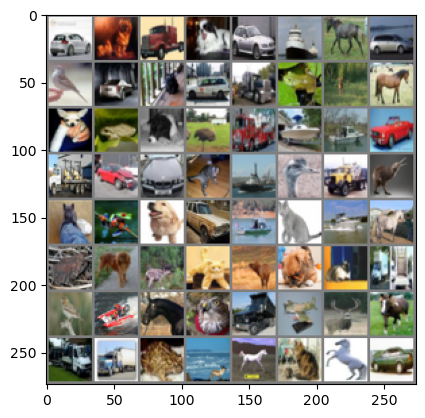

  car   dog truck   dog


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
# define a simple CNN module
class SimpleCNN(nn.Module):
    def __init__(self, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        residual = x if self.use_residual else None
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        if self.use_residual and residual is not None:
            x += residual
        
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [5]:
# 
def train_and_validate(model, trainloader, valloader, criterion, optimizer, scheduler=None, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_losses.append(running_loss / total)
        train_accuracies.append(100. * correct / total)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_losses.append(val_loss / val_total)
        val_accuracies.append(100. * val_correct / val_total)
        
        if scheduler:
            scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [6]:
import torch.optim as optim

hyperparams = [
    {'optimizer': optim.SGD, 'lr': 0.01},
    {'optimizer': optim.Adam, 'lr': 0.001},
    {'optimizer': optim.Adam, 'lr': 0.0005},
    {'optimizer': optim.SGD, 'lr': 0.005, 'momentum': 0.9}
]

results = []
for params in hyperparams:
    print(f"Training with {params['optimizer'].__name__}, learning rate: {params['lr']}")
    model = SimpleCNN(use_residual=False)
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_acc, val_acc = train_and_validate(
        model, trainloader, valloader, criterion, optimizer, num_epochs=10)
    results.append((train_losses, val_losses, train_acc, val_acc))


Training with SGD, learning rate: 0.01


Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 2.2825, Train Acc: 13.84%
Validation Loss: 2.1950, Validation Acc: 23.30%


Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 2.0147, Train Acc: 27.02%
Validation Loss: 1.8916, Validation Acc: 32.06%


Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 1.7874, Train Acc: 35.15%
Validation Loss: 1.6927, Validation Acc: 37.58%


Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 1.6285, Train Acc: 40.75%
Validation Loss: 1.6372, Validation Acc: 41.56%


Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 1.5367, Train Acc: 43.86%
Validation Loss: 1.5498, Validation Acc: 43.84%


Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 1.4651, Train Acc: 46.44%
Validation Loss: 1.5343, Validation Acc: 43.74%


Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 1.4078, Train Acc: 48.93%
Validation Loss: 1.3799, Validation Acc: 49.30%


Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 1.3512, Train Acc: 50.90%
Validation Loss: 1.3392, Validation Acc: 51.64%


Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 1.3039, Train Acc: 53.07%
Validation Loss: 1.2799, Validation Acc: 54.16%


Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 1.2581, Train Acc: 54.84%
Validation Loss: 1.2359, Validation Acc: 54.92%
Training with Adam, learning rate: 0.001


Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.4765, Train Acc: 45.94%
Validation Loss: 1.1713, Validation Acc: 57.68%


Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 1.0691, Train Acc: 61.84%
Validation Loss: 0.9315, Validation Acc: 68.50%


Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.8804, Train Acc: 68.91%
Validation Loss: 0.8512, Validation Acc: 69.76%


Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.7700, Train Acc: 73.20%
Validation Loss: 0.7638, Validation Acc: 73.60%


Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.6799, Train Acc: 76.27%
Validation Loss: 0.7331, Validation Acc: 74.22%


Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.6136, Train Acc: 78.55%
Validation Loss: 0.6969, Validation Acc: 75.16%


Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.5503, Train Acc: 80.62%
Validation Loss: 0.6649, Validation Acc: 77.18%


Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.4927, Train Acc: 82.64%
Validation Loss: 0.7016, Validation Acc: 76.72%


Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.4437, Train Acc: 84.27%
Validation Loss: 0.7252, Validation Acc: 76.62%


Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.3973, Train Acc: 85.95%
Validation Loss: 0.7205, Validation Acc: 76.62%
Training with Adam, learning rate: 0.0005


Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.5547, Train Acc: 43.13%
Validation Loss: 1.2636, Validation Acc: 54.44%


Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 1.1962, Train Acc: 56.96%
Validation Loss: 1.0784, Validation Acc: 61.64%


Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 1.0272, Train Acc: 63.51%
Validation Loss: 0.9281, Validation Acc: 67.12%


Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.8983, Train Acc: 68.18%
Validation Loss: 0.8716, Validation Acc: 69.34%


Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.8149, Train Acc: 71.36%
Validation Loss: 0.8104, Validation Acc: 71.82%


Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.7289, Train Acc: 74.46%
Validation Loss: 0.7673, Validation Acc: 73.64%


Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.6674, Train Acc: 76.46%
Validation Loss: 0.7241, Validation Acc: 74.98%


Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.6007, Train Acc: 78.78%
Validation Loss: 0.7318, Validation Acc: 75.16%


Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.5460, Train Acc: 80.59%
Validation Loss: 0.7098, Validation Acc: 75.28%


Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.4977, Train Acc: 82.55%
Validation Loss: 0.6680, Validation Acc: 77.24%
Training with SGD, learning rate: 0.005


Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 2.2920, Train Acc: 13.47%
Validation Loss: 2.2731, Validation Acc: 15.74%


Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 2.1824, Train Acc: 21.36%
Validation Loss: 2.0534, Validation Acc: 25.88%


Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 1.9936, Train Acc: 28.14%
Validation Loss: 1.9169, Validation Acc: 30.98%


Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 1.8713, Train Acc: 32.60%
Validation Loss: 1.7990, Validation Acc: 35.42%


Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 1.7655, Train Acc: 36.56%
Validation Loss: 1.7380, Validation Acc: 37.16%


Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 1.6803, Train Acc: 39.41%
Validation Loss: 1.7907, Validation Acc: 35.48%


Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 1.6116, Train Acc: 41.49%
Validation Loss: 1.5823, Validation Acc: 43.78%


Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 1.5565, Train Acc: 43.70%
Validation Loss: 1.5240, Validation Acc: 44.52%


Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 1.5099, Train Acc: 45.32%
Validation Loss: 1.4721, Validation Acc: 46.38%


Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 1.4686, Train Acc: 46.86%
Validation Loss: 1.4549, Validation Acc: 47.72%


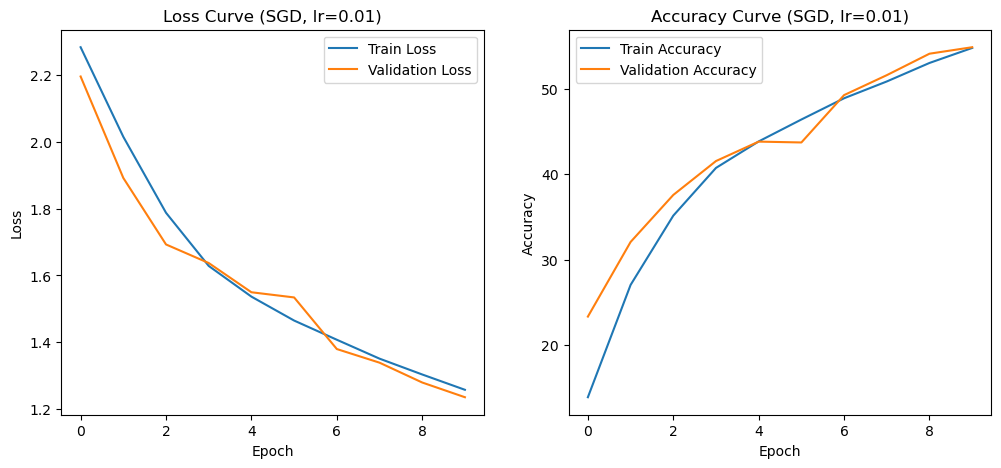

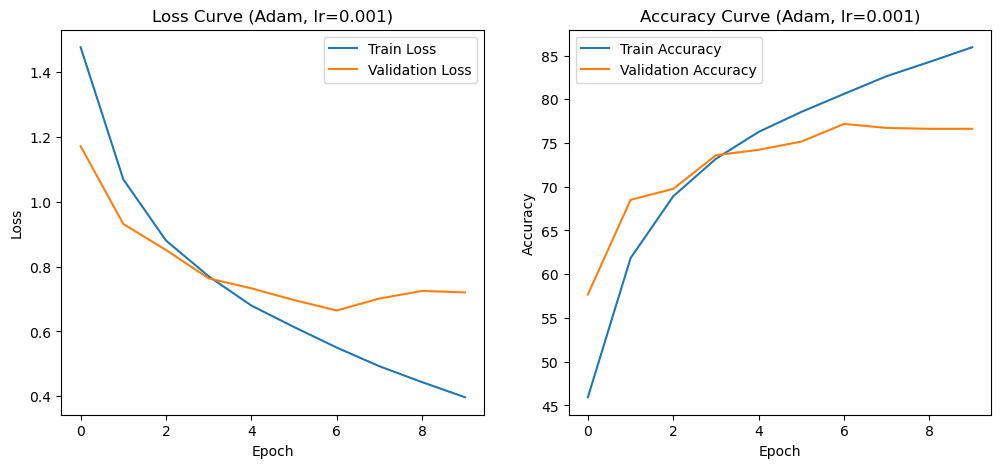

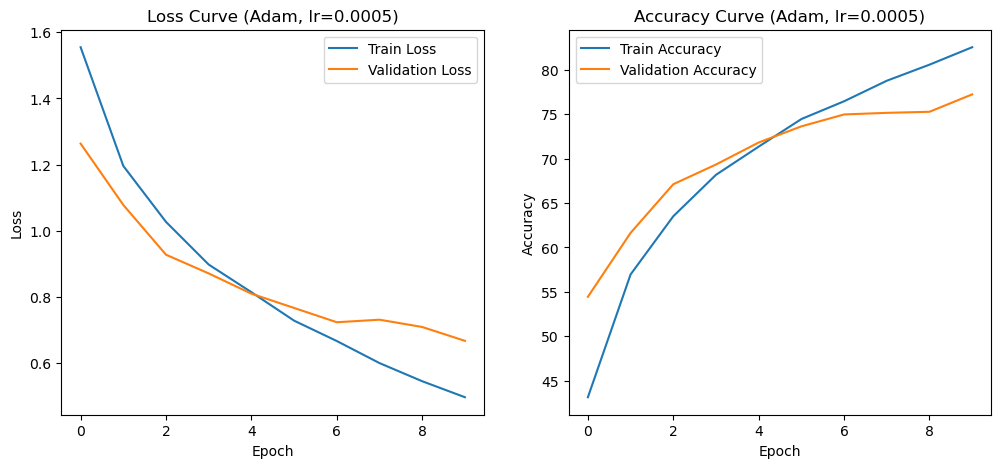

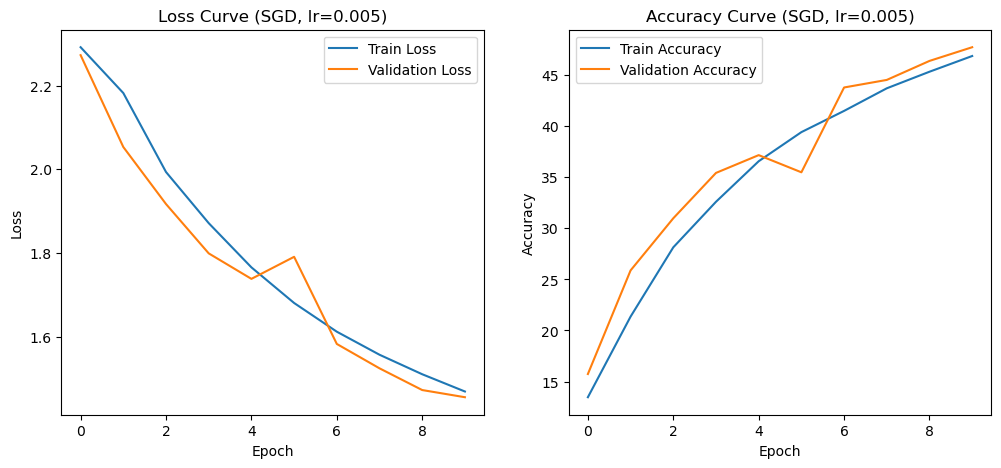

In [7]:
def plot_results(results, hyperparams):
    for i, (train_losses, val_losses, train_acc, val_acc) in enumerate(results):
        plt.figure(figsize=(12, 5))
        
        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f"Loss Curve ({hyperparams[i]['optimizer'].__name__}, lr={hyperparams[i]['lr']})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title(f"Accuracy Curve ({hyperparams[i]['optimizer'].__name__}, lr={hyperparams[i]['lr']})")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()

plot_results(results, hyperparams)
